In [15]:
# Cell 1: imports & plotting style

import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import ipywidgets as widgets
    from IPython.display import display
    HAVE_WIDGETS = True
except ImportError:
    HAVE_WIDGETS = False
    print("ipywidgets not available; interactive UI will be skipped.")

# ---- Global plotting style (paper-ready) ----
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "axes.facecolor": "white",
    "grid.color": "0.8",
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "axes.grid": True,
    "font.size": 11,
    "font.family": "serif",
    "lines.linewidth": 2.0,
    "lines.markersize": 6,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.edgecolor": "black",
})

In [16]:
# Cell 2: data structures

@dataclass
class Task:
    name: str
    period_ms: float
    exec_ms: float
    deadline_ms: float = None

    def __post_init__(self):
        if self.deadline_ms is None:
            self.deadline_ms = self.period_ms


@dataclass
class Job:
    scheduler: str
    task: str
    alpha: float
    release: float
    deadline: float
    start: float
    finish: float
    response: float
    tardiness: float
    miss: int
    utility: float


def task_set_utilization(tasks: List[Task]) -> float:
    """Sum C_i / T_i."""
    return sum(t.exec_ms / t.period_ms for t in tasks)

In [17]:
# Cell 3: generic single-CPU scheduler simulator

def simulate_generic(
    tasks: List[Task],
    scheduler_name: str,
    sim_time_ms: float,
    alpha_load: float = 1.0,
    dt_ms: float = 1.0,
    util_scale_ms: float = 50.0,
) -> Tuple[List[Job], Dict[str, float]]:
    """
    Simulate EDF / RM / FIFO on a single core.

    - tasks: base task set (period, exec, deadline)
    - scheduler_name: "EDF", "RM", or "FIFO"
    - alpha_load: scales execution times (C' = alpha * C)
    - dt_ms: time step when idle
    - util_scale_ms: characteristic time for utility

    Returns:
      jobs_out: list[Job]
      effort:  dict with keys: scheduler, alpha, util, steps, steps_per_job
    """

    # Scale exec time to change utilization
    scaled_tasks = [
        Task(t.name, t.period_ms, t.exec_ms * alpha_load, t.deadline_ms)
        for t in tasks
    ]

    # Precompute base utilization (for reporting only)
    U_base = task_set_utilization(tasks)
    U_alpha = U_base * alpha_load

    t = 0.0
    ready = []  # elements: [Task, release, abs_deadline, remaining_exec]
    next_release = {t.name: 0.0 for t in scaled_tasks}

    jobs_out: List[Job] = []
    steps = 0  # "effort" ~ number of job selections

    def pick_job():
        if not ready:
            return None

        # each pick counts as one "step"
        nonlocal steps
        steps += 1

        if scheduler_name == "EDF":
            # earliest absolute deadline
            return min(ready, key=lambda x: x[2])

        elif scheduler_name == "RM":
            # shortest period first
            return min(ready, key=lambda x: x[0].period_ms)

        elif scheduler_name == "FIFO":
            # earliest release first
            return min(ready, key=lambda x: x[1])

        else:
            raise ValueError(f"Unknown scheduler: {scheduler_name}")

    while t < sim_time_ms:
        # Release new jobs
        for ti in scaled_tasks:
            if t >= next_release[ti.name] - 1e-9:
                rel = next_release[ti.name]
                abs_dl = rel + ti.deadline_ms
                ready.append([ti, rel, abs_dl, ti.exec_ms])
                next_release[ti.name] += ti.period_ms

        job = pick_job()
        if job is None:
            t += dt_ms
            continue

        task, rel, abs_dl, rem = job
        start = t
        finish = t + rem
        t = finish

        response = finish - rel
        tardiness = max(0.0, finish - abs_dl)
        miss = 1 if finish > abs_dl + 1e-9 else 0

        # latency-based utility (decays with response time)
        utility = math.exp(-response / util_scale_ms)

        jobs_out.append(
            Job(
                scheduler=scheduler_name,
                task=task.name,
                alpha=alpha_load,
                release=rel,
                deadline=abs_dl,
                start=start,
                finish=finish,
                response=response,
                tardiness=tardiness,
                miss=miss,
                utility=utility,
            )
        )

        ready.remove(job)

    n_jobs = len(jobs_out)
    effort = dict(
        scheduler=scheduler_name,
        alpha=alpha_load,
        util=U_alpha,
        steps=steps,
        steps_per_job=(steps / n_jobs) if n_jobs > 0 else 0.0,
    )

    return jobs_out, effort


def summarize_jobs_with_metrics(jobs: List[Job]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Create df_jobs and df_summary with latency, jitter, tardiness, miss ratio, utility."""
    if not jobs:
        cols_jobs = [
            "scheduler", "task", "alpha",
            "release", "deadline", "start", "finish",
            "response", "tardiness", "miss", "utility"
        ]
        cols_sum = [
            "scheduler", "task", "alpha",
            "avg_latency_ms", "jitter_ms",
            "avg_tardiness_ms", "miss_ratio", "avg_utility"
        ]
        return pd.DataFrame(columns=cols_jobs), pd.DataFrame(columns=cols_sum)

    df = pd.DataFrame([j.__dict__ for j in jobs])

    group_cols = ["scheduler", "task", "alpha"]
    g = df.groupby(group_cols)

    summary = g.agg(
        avg_latency_ms=("response", "mean"),
        jitter_ms=("response", "std"),
        avg_tardiness_ms=("tardiness", "mean"),
        miss_ratio=("miss", "mean"),
        avg_utility=("utility", "mean"),
    ).reset_index()

    summary["jitter_ms"] = summary["jitter_ms"].fillna(0.0)

    return df, summary

In [18]:
# Cell 4: plotting functions

def plot_latency_vs_alpha_multi(df_summary, title):
    plt.figure(figsize=(6, 4))
    for sched in sorted(df_summary["scheduler"].unique()):
        sub = (df_summary[df_summary["scheduler"] == sched]
               .groupby("alpha")["avg_latency_ms"]
               .mean()
               .reset_index())
        plt.plot(sub["alpha"], sub["avg_latency_ms"], marker="o", label=sched)
    plt.xlabel("Load factor α")
    plt.ylabel("Average response time [ms]")
    plt.title(title)
    plt.grid(True)
    plt.legend(title="Scheduler")
    plt.tight_layout()
    plt.show()


def plot_miss_ratio_vs_alpha(df_summary, title):
    plt.figure(figsize=(6, 4))
    for sched in sorted(df_summary["scheduler"].unique()):
        sub = (df_summary[df_summary["scheduler"] == sched]
               .groupby("alpha")["miss_ratio"]
               .mean()
               .reset_index())
        plt.plot(sub["alpha"], sub["miss_ratio"], marker="s", label=sched)
    plt.xlabel("Load factor α")
    plt.ylabel("Deadline miss ratio")
    plt.title(title)
    plt.grid(True)
    plt.legend(title="Scheduler")
    plt.tight_layout()
    plt.show()


def plot_jitter_vs_alpha(df_summary, title):
    plt.figure(figsize=(6, 4))
    for sched in sorted(df_summary["scheduler"].unique()):
        sub = (df_summary[df_summary["scheduler"] == sched]
               .groupby("alpha")["jitter_ms"]
               .mean()
               .reset_index())
        plt.plot(sub["alpha"], sub["jitter_ms"], marker="^", label=sched)
    plt.xlabel("Load factor α")
    plt.ylabel("Latency jitter [ms] (std dev)")
    plt.title(title)
    plt.grid(True)
    plt.legend(title="Scheduler")
    plt.tight_layout()
    plt.show()


def plot_effort_vs_util(df_effort, title_max, title_avg):
    # max effort vs utilization
    plt.figure(figsize=(6, 4))
    for sched in sorted(df_effort["scheduler"].unique()):
        sub = df_effort[df_effort["scheduler"] == sched]
        plt.plot(sub["util"] * 100.0, sub["steps"], marker="o", label=sched)
    plt.xlabel("Utilization [%]")
    plt.ylabel("Max effort (steps)")
    plt.title(title_max)
    plt.grid(True)
    plt.legend(title="Scheduler")
    plt.tight_layout()
    plt.show()

    # avg effort per job vs utilization
    plt.figure(figsize=(6, 4))
    for sched in sorted(df_effort["scheduler"].unique()):
        sub = df_effort[df_effort["scheduler"] == sched]
        plt.plot(sub["util"] * 100.0, sub["steps_per_job"], marker="o", label=sched)
    plt.xlabel("Utilization [%]")
    plt.ylabel("Average effort per job [steps/job]")
    plt.title(title_avg)
    plt.grid(True)
    plt.legend(title="Scheduler")
    plt.tight_layout()
    plt.show()


def plot_frame_delay_hist(df_jobs, task_name, scheduler):
    sub = df_jobs[(df_jobs["task"] == task_name) &
                  (df_jobs["scheduler"] == scheduler)]
    plt.figure(figsize=(6, 4))
    plt.hist(sub["response"], bins=25, color="steelblue",
             edgecolor="black", alpha=0.85)
    plt.xlabel("Response time [ms]")
    plt.ylabel("Frequency")
    plt.title(f"Frame delay distribution – {task_name} ({scheduler})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_tardiness_vs_time(df_jobs, task_name, scheduler):
    sub = (df_jobs[(df_jobs["task"] == task_name) &
                   (df_jobs["scheduler"] == scheduler)]
           .sort_values("release"))
    plt.figure(figsize=(6, 4))
    plt.plot(sub["release"], sub["tardiness"],
             marker=".", linestyle="-", color="darkred")
    plt.xlabel("Release time [ms]")
    plt.ylabel("Tardiness [ms]")
    plt.title(f"Tardiness over time – {task_name} ({scheduler})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_dashboard(df_summary, df_jobs, df_effort, example_task, title_prefix=""):
    """2x2 'paper' figure for one scenario (generic OR project)."""
    schedulers = sorted(df_summary["scheduler"].unique())
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    ax1, ax2, ax3, ax4 = axs.ravel()

    # 1) Latency vs alpha (mean over tasks per scheduler)
    for sched in schedulers:
        sub = (df_summary[df_summary["scheduler"] == sched]
               .groupby("alpha")["avg_latency_ms"]
               .mean()
               .reset_index())
        ax1.plot(sub["alpha"], sub["avg_latency_ms"], marker="o", label=sched)
    ax1.set_xlabel("Load factor α")
    ax1.set_ylabel("Average response time [ms]")
    ax1.set_title("Average latency vs load")
    ax1.legend(title="Scheduler")

    # 2) Miss ratio vs alpha
    for sched in schedulers:
        sub = (df_summary[df_summary["scheduler"] == sched]
               .groupby("alpha")["miss_ratio"]
               .mean()
               .reset_index())
        ax2.plot(sub["alpha"], sub["miss_ratio"], marker="s", label=sched)
    ax2.set_xlabel("Load factor α")
    ax2.set_ylabel("Deadline miss ratio")
    ax2.set_title("Deadline miss ratio vs load")
    ax2.legend(title="Scheduler")

    # 3) Effort vs utilization (max)
    for sched in schedulers:
        sub = df_effort[df_effort["scheduler"] == sched]
        ax3.plot(sub["util"] * 100.0, sub["steps"], marker="o", label=sched)
    ax3.set_xlabel("Utilization [%]")
    ax3.set_ylabel("Max effort (steps)")
    ax3.set_title("Scheduler effort vs utilization")
    ax3.legend(title="Scheduler")

    # 4) Per-task tardiness for example_task under EDF
    if "EDF" in schedulers:
        sched_for_tard = "EDF"
    else:
        sched_for_tard = schedulers[0]

    sub = (df_jobs[(df_jobs["task"] == example_task) &
                   (df_jobs["scheduler"] == sched_for_tard)]
           .sort_values("release"))
    ax4.plot(sub["release"], sub["tardiness"],
             marker=".", linestyle="-", color="darkred")
    ax4.set_xlabel("Release time [ms]")
    ax4.set_ylabel("Tardiness [ms]")
    ax4.set_title(f"Tardiness over time – {example_task} ({sched_for_tard})")

    fig.suptitle(title_prefix, fontsize=15, weight="bold")
    fig.tight_layout()
    plt.show()

In [19]:
# Cell 5: generic experiment (interactive if widgets available)

def run_generic_experiment(n_tasks, base_T, base_C, sim_time_ms, alpha_list):
    # simple uniform task set: all tasks same T, C, D=T
    tasks = [
        Task(name=f"Task{i+1}", period_ms=base_T, exec_ms=base_C, deadline_ms=base_T)
        for i in range(n_tasks)
    ]

    all_jobs = []
    effort_rows = []

    for alpha in alpha_list:
        for sched in ["EDF", "RM", "FIFO"]:
            jobs, effort = simulate_generic(
                tasks,
                scheduler_name=sched,
                sim_time_ms=sim_time_ms,
                alpha_load=alpha,
                dt_ms=1.0,
                util_scale_ms=50.0,
            )
            all_jobs.extend(jobs)
            effort_rows.append(effort)

    df_jobs, df_summary = summarize_jobs_with_metrics(all_jobs)
    df_effort = pd.DataFrame(effort_rows)
    return tasks, df_jobs, df_summary, df_effort


def parse_alpha_list(text: str) -> List[float]:
    parts = [p.strip() for p in text.split(",") if p.strip()]
    vals = []
    for p in parts:
        try:
            vals.append(float(p))
        except ValueError:
            print(f"Ignoring invalid α='{p}'")
    return vals


def run_generic_from_ui(n_tasks, base_T, base_C, sim_time_ms, alpha_text):
    alpha_list = parse_alpha_list(alpha_text)
    print("Sensors:", n_tasks)
    print("Period T [ms]:", base_T)
    print("Exec C [ms]:", base_C)
    print("Sim time [ms]:", sim_time_ms)
    print("α list:", alpha_list)

    tasks, df_jobs, df_summary, df_effort = run_generic_experiment(
        n_tasks, base_T, base_C, sim_time_ms, alpha_list
    )

    print("Total jobs:", len(df_jobs))
    print("Writing CSV: edf_jobs_generic.csv, edf_summary_generic.csv, edf_effort_generic.csv")
    df_jobs.to_csv("edf_jobs_generic.csv", index=False)
    df_summary.to_csv("edf_summary_generic.csv", index=False)
    df_effort.to_csv("edf_effort_generic.csv", index=False)

    example_task = tasks[0].name
    plot_dashboard(
        df_summary,
        df_jobs,
        df_effort,
        example_task,
        title_prefix="Generic task set: EDF vs RM vs FIFO",
    )


if HAVE_WIDGETS:
    sensors_slider = widgets.IntSlider(value=4, min=1, max=20, step=1, description="Sensors:")
    T_slider = widgets.FloatSlider(value=100.0, min=10.0, max=1000.0,
                                   step=10.0, description="Period T [ms]:")
    C_slider = widgets.FloatSlider(value=5.0, min=0.5, max=50.0,
                                   step=0.5, description="Exec C [ms]:")
    sim_time_box = widgets.FloatText(value=60_000.0, description="Sim time [ms]:")
    alpha_box = widgets.Text(value="0.5,0.75,1.0,1.25,1.5", description="α list:")

    ui = widgets.VBox([
        widgets.HBox([sensors_slider, T_slider, C_slider]),
        widgets.HBox([sim_time_box, alpha_box]),
    ])

    out = widgets.interactive_output(
        run_generic_from_ui,
        {
            "n_tasks": sensors_slider,
            "base_T": T_slider,
            "base_C": C_slider,
            "sim_time_ms": sim_time_box,
            "alpha_text": alpha_box,
        },
    )

    display(ui)
    display(out)
else:
    print("ipywidgets not available; call run_generic_from_ui(...) manually.")

Output()

Base utilization U = 0.023
[PROJECT] EDF α=0.5: 570 jobs
[PROJECT] RM α=0.5: 570 jobs
[PROJECT] FIFO α=0.5: 570 jobs
[PROJECT] EDF α=0.75: 570 jobs
[PROJECT] RM α=0.75: 570 jobs
[PROJECT] FIFO α=0.75: 570 jobs
[PROJECT] EDF α=1.0: 570 jobs
[PROJECT] RM α=1.0: 570 jobs
[PROJECT] FIFO α=1.0: 570 jobs
[PROJECT] EDF α=1.25: 570 jobs
[PROJECT] RM α=1.25: 570 jobs
[PROJECT] FIFO α=1.25: 570 jobs
[PROJECT] EDF α=1.5: 570 jobs
[PROJECT] RM α=1.5: 570 jobs
[PROJECT] FIFO α=1.5: 570 jobs

Writing project CSVs: edf_jobs_project.csv, edf_summary_project.csv, edf_effort_project.csv


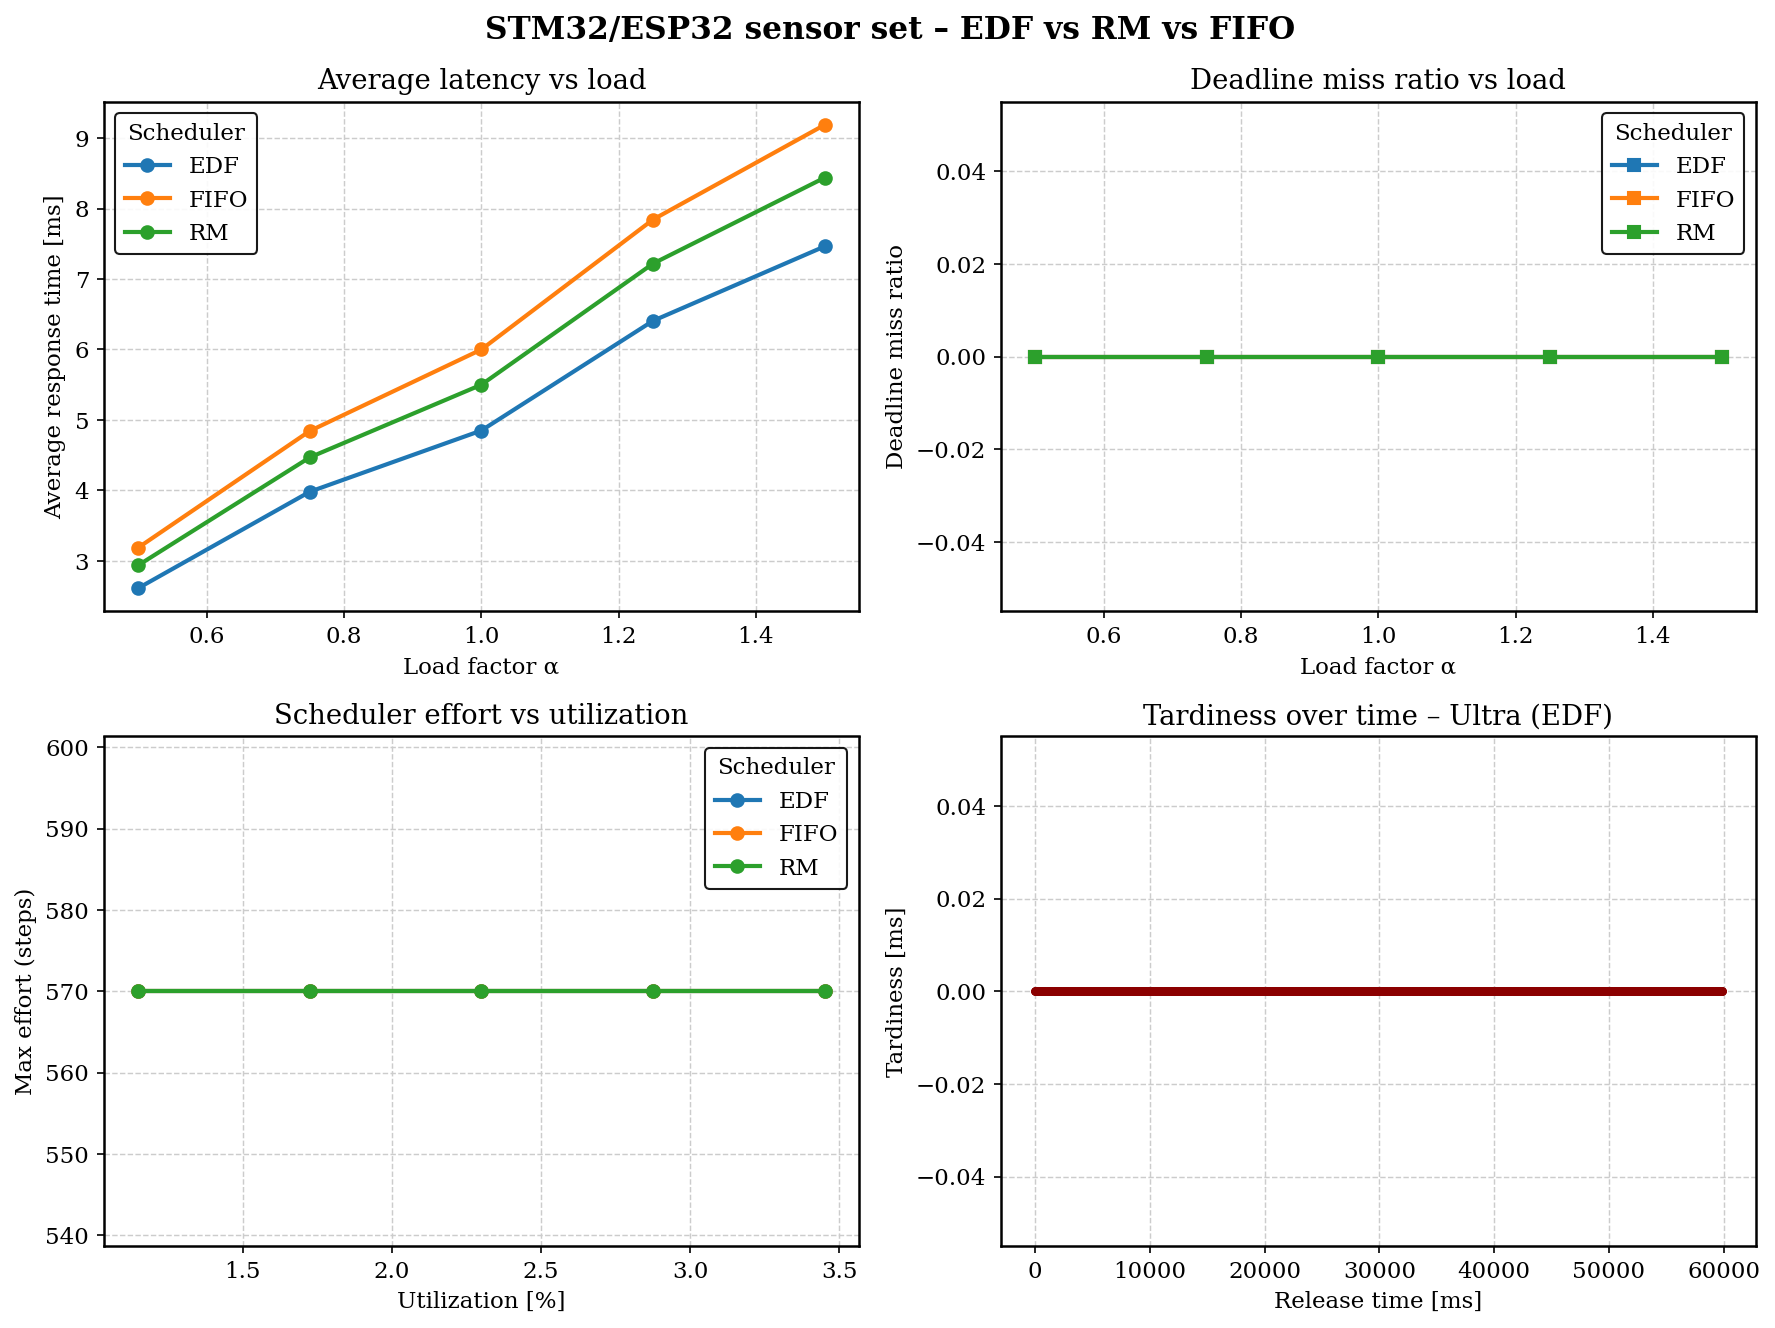

In [20]:
# Cell 6: STM32/ESP32 project task set experiment

# Realistic task set matching your project
tasks_project = [
    Task("Ultra",  period_ms=200,  exec_ms=3,  deadline_ms=200),
    Task("Sound",  period_ms=2000, exec_ms=8,  deadline_ms=2000),
    Task("PIR",    period_ms=500,  exec_ms=1,  deadline_ms=100),
    Task("Button", period_ms=500,  exec_ms=1,  deadline_ms=150),
]

print("Base utilization U =", task_set_utilization(tasks_project))

sim_time_ms_proj = 60_000.0
alpha_list_proj  = [0.5, 0.75, 1.0, 1.25, 1.5]   # you can tweak this later

all_jobs_proj = []
effort_rows_proj = []

for alpha in alpha_list_proj:
    for sched in ["EDF", "RM", "FIFO"]:
        jobs, effort = simulate_generic(
            tasks_project,
            scheduler_name=sched,
            sim_time_ms=sim_time_ms_proj,
            alpha_load=alpha,
            dt_ms=1.0,
            util_scale_ms=50.0,
        )
        print(f"[PROJECT] {sched} α={alpha}: {len(jobs)} jobs")
        all_jobs_proj.extend(jobs)
        effort_rows_proj.append(effort)

df_jobs_project, df_summary_project = summarize_jobs_with_metrics(all_jobs_proj)
df_effort_project = pd.DataFrame(effort_rows_proj)

print("\nWriting project CSVs: edf_jobs_project.csv, edf_summary_project.csv, edf_effort_project.csv")
df_jobs_project.to_csv("edf_jobs_project.csv", index=False)
df_summary_project.to_csv("edf_summary_project.csv", index=False)
df_effort_project.to_csv("edf_effort_project.csv", index=False)

example_task_proj = "Ultra"  # or "PIR" etc.

plot_dashboard(
    df_summary_project,
    df_jobs_project,
    df_effort_project,
    example_task_proj,
    title_prefix="STM32/ESP32 sensor set – EDF vs RM vs FIFO",
)

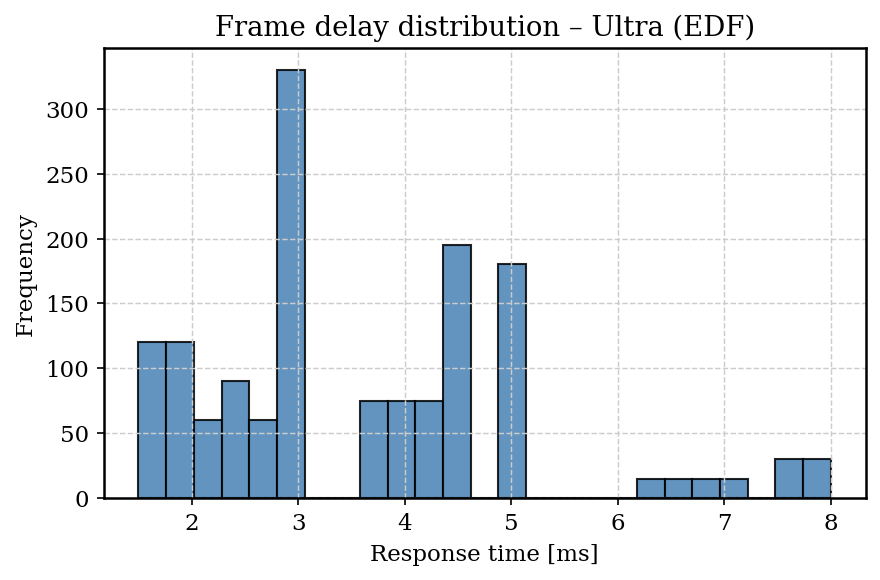

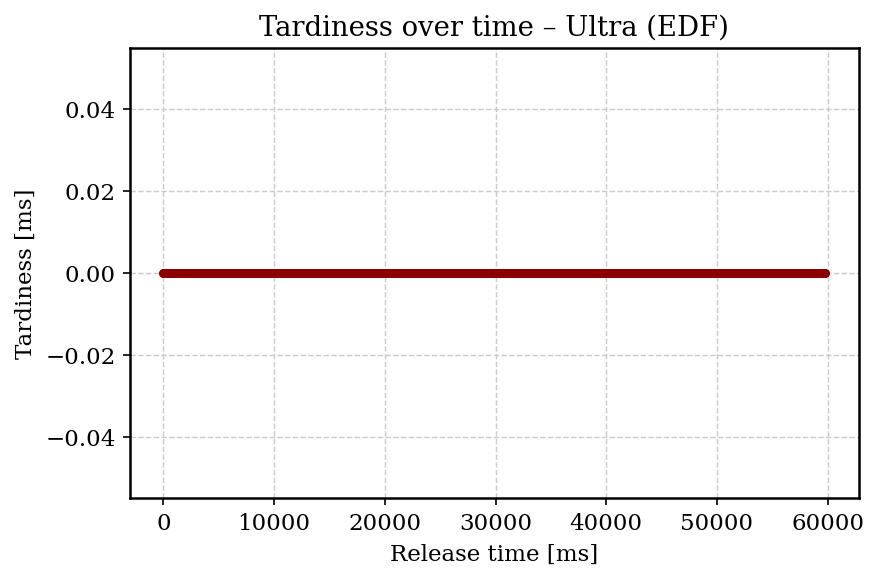

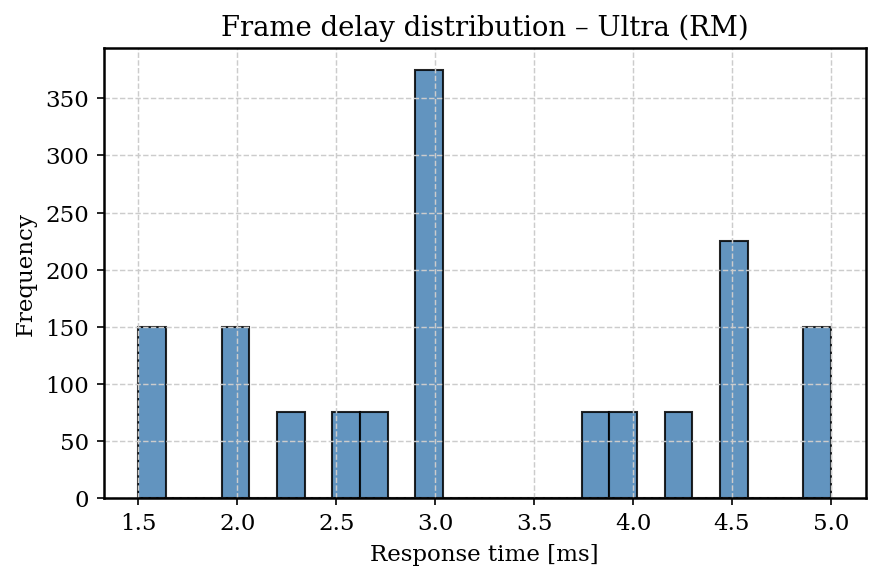

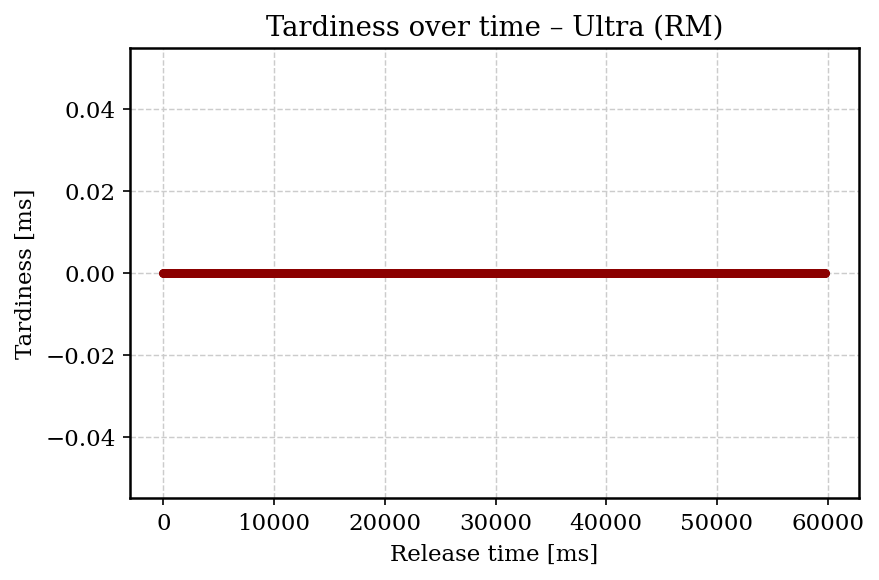

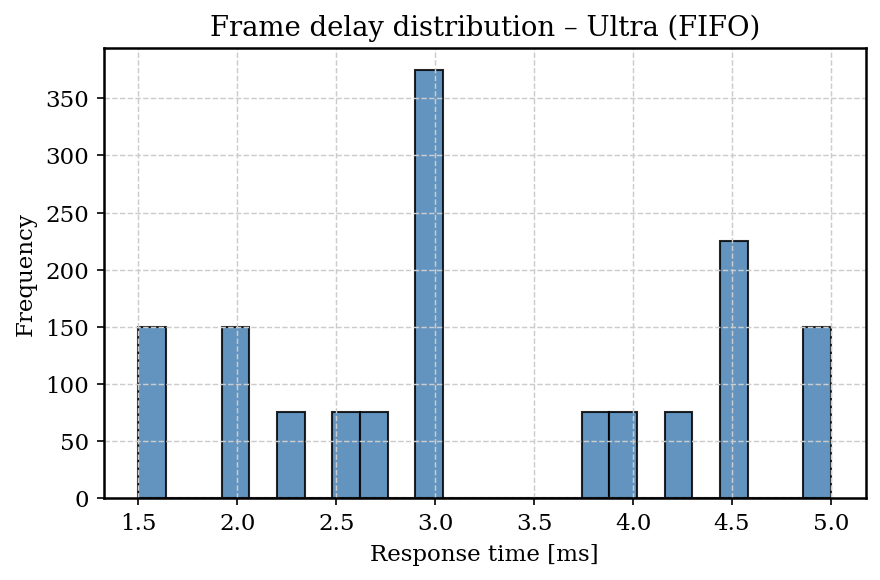

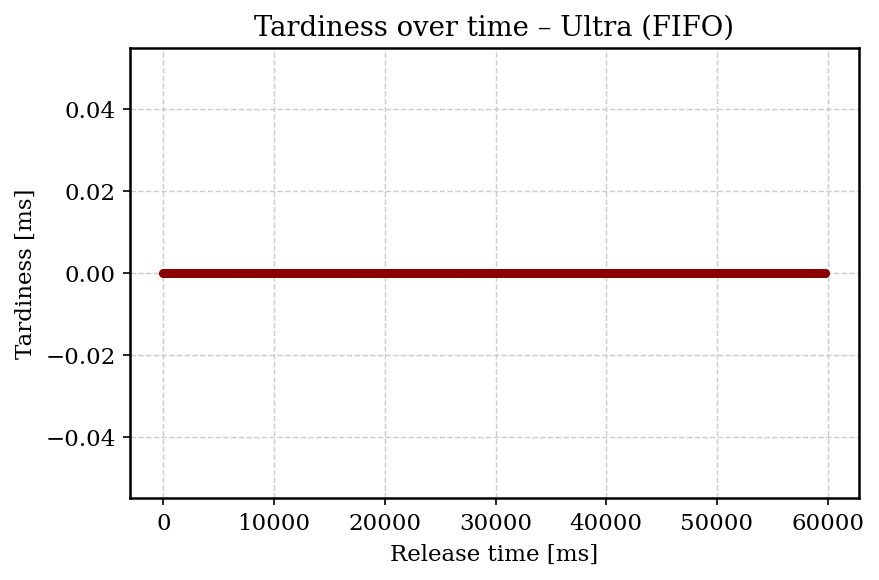

In [21]:
# Extra per-task inspection (optional)
for sched in ["EDF", "RM", "FIFO"]:
    plot_frame_delay_hist(df_jobs_project, "Ultra", sched)
    plot_tardiness_vs_time(df_jobs_project, "Ultra", sched)